In [1]:
import pandas as pd

# import modules from other folders
# source: https://stackoverflow.com/questions/49264194/import-py-file-in-another-directory-in-jupyter-notebook
# author: adhg (accessed 15 June 2025)
import os
import sys

# Build an absolute path from this notebook's parent directory
module_path = os.path.abspath(os.path.join('..', 'src/python'))
# Add to sys.path if not already present
if module_path not in sys.path:
    sys.path.append(module_path)

import config as cfg
from data_load import read_dataset
from train_rule_classifier import train_rule_classifier
from kb_feature_extraction import extract_features

In [2]:
df_train = read_dataset(cfg.TRAIN_DATASET_PATH)
df_test = read_dataset(cfg.TEST_DATASET_PATH)

# split the training set into training and validation for hold-out validation
from sklearn.model_selection import train_test_split

X = df_train[["text"]]
y = df_train["label"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=1)

In [3]:
# train the rule based classifier

train_rule_classifier(X_train)

In [5]:
# create a new validation set with features extracted from the KB

X_val = extract_features(X_val, False)

#### Review statistics by label to find a suitable threshold

In [6]:
# define function for plotting
# written by ChatGPT

import matplotlib.pyplot as plt

def plot_histogram_metric(df, metric, label_col='label', bins=30):
    """
    Disegna due istogrammi sovrapposti di 'metric' per le due classi indicate in label_col (0 e 1).
    df: DataFrame con almeno le colonne metric e label_col.
    metric: nome della colonna numerica da visualizzare.
    label_col: nome della colonna con valori 0/1 (o equivalenti).
    bins: numero di bin per l'istogramma.
    """
    # Estrai valori per ciascuna classe
    vals_pos = df[df[label_col] == 1][metric].dropna()
    vals_neg = df[df[label_col] == 0][metric].dropna()
    plt.figure()
    plt.hist(vals_pos, bins=bins, alpha=0.6, label='Positive')
    plt.hist(vals_neg, bins=bins, alpha=0.6, label='Negative')
    plt.xlabel(metric)
    plt.ylabel('Count')
    plt.title(f'Distribution of {metric} by label')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

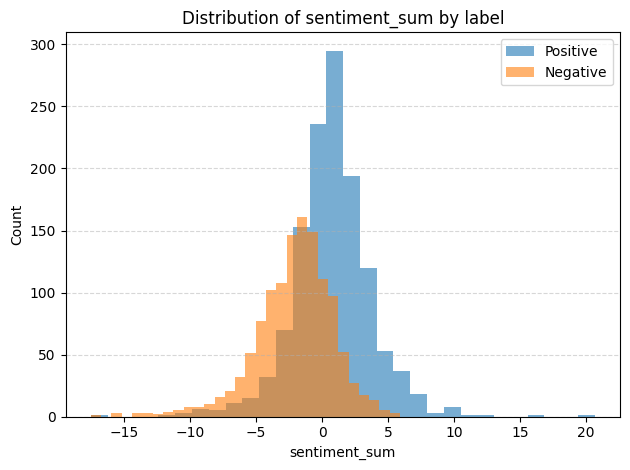

In [7]:
Xv = X_val.reset_index(drop=True)
yv = y_val.reset_index(drop=True).to_frame(name="label")
plot_histogram_metric(pd.concat([Xv, yv], axis=1), "sentiment_sum")

In [8]:
pd.concat([Xv, yv], axis=1).groupby("label")["sentiment_sum"].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,1235.0,-2.154046,3.002098,-17.5257,-3.75065,-1.81900,-0.2454,5.89880
1,1265.0,0.728760,2.996951,-17.4873,-0.87650,0.77496,2.3025,20.65038


#### Validate multiple thresholds 

In [9]:
# define functions
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def plot_ROC(y_true, feature, calculate_optimal=False):
    fpr, tpr, thresholds = roc_curve(y_true, feature)
    auc_score = roc_auc_score(y_true, feature)

    plt.figure(figsize=(7, 6))

    # calculate optimal threshold
    if calculate_optimal:
        j_scores = tpr - fpr  # Youden's J statistic
        optimal_idx = np.argmax(j_scores)
        optimal_threshold = thresholds[optimal_idx]
        
        plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', s=80,
                    label=f'Optimal Threshold: {optimal_threshold:.3f}')
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.3f})', color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    if calculate_optimal:
        return optimal_threshold

def evaluate_thresholds(num_thresholds=100):
    # convert to numpy array
    feat = np.asarray(X_val["sentiment_sum"])
    lab = np.asarray(y_val)
    
    # define thresholds
    min_val, max_val = np.min(feat), np.max(feat)
    thresholds = np.linspace(min_val, max_val, num_thresholds)

    # evaluate
    results = []
    for thr in thresholds:
        y_pred = [1 if sentiment >= thr else 0 for sentiment in X_val["sentiment_sum"]]
        
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred, zero_division=0)
        recall = recall_score(y_val, y_pred, zero_division=0)

        results.append({
                'threshold': thr,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
        })

    df_metrics = pd.DataFrame(results)

    return df_metrics

def plot_metrics_vs_threshold(df_metrics, optimal_threshold=None):
    plt.figure(figsize=(8, 6))
    for col in ['accuracy', 'precision', 'recall']:
        plt.plot(df_metrics['threshold'], df_metrics[col], label=col)

    if optimal_threshold is not None:
        plt.axvline(optimal_threshold, color='red', linestyle='--', label=f'optimal threshold : {optimal_threshold:.3f}')

    plt.xlabel('Threshold')
    plt.ylabel('Valore metrica')
    plt.title('Metriche vs Threshold')
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

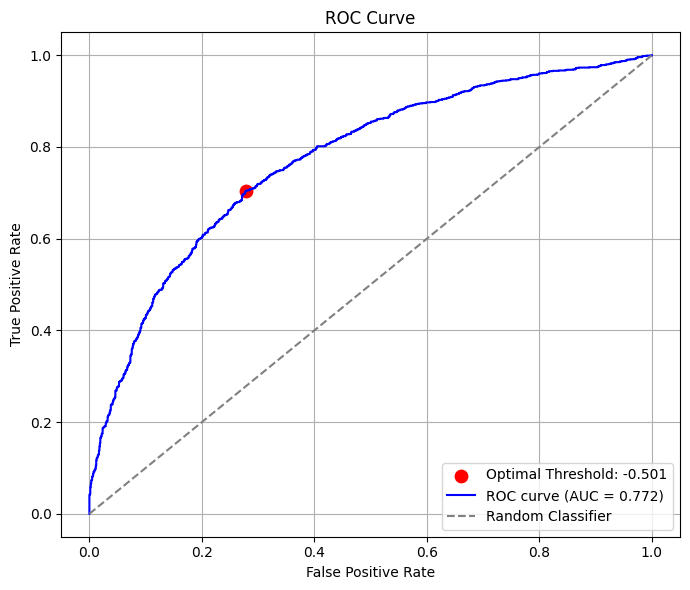

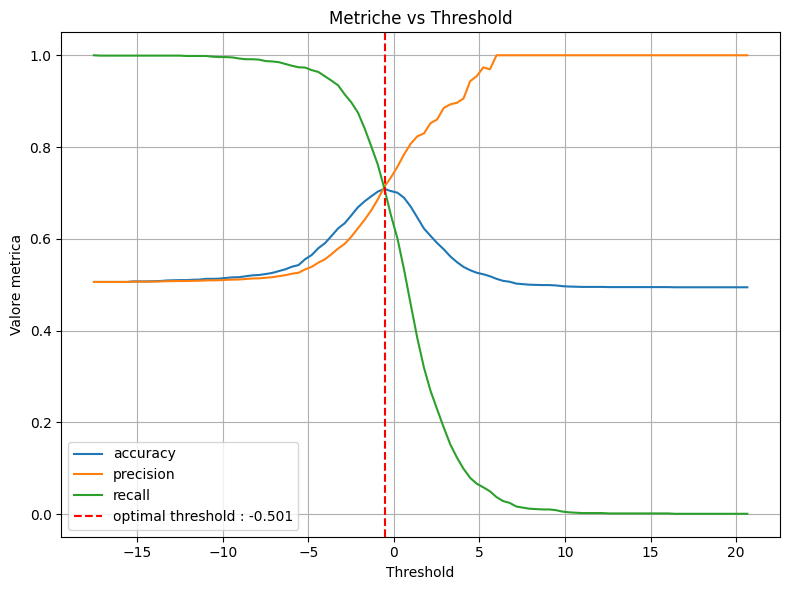

Optimal threshold: -0.501
Accuracy for optimal threshold: 0.713
Precision for optimal threshold: 0.722
Recall for optimal threshold: 0.704


In [10]:
optimal_threshold = plot_ROC(y_val, X_val["sentiment_sum"], True)
plot_metrics_vs_threshold(evaluate_thresholds(), optimal_threshold)

# print metrics for optimal threshold
y_pred = [1 if sentiment >= optimal_threshold else 0 for sentiment in X_val["sentiment_sum"]]
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, zero_division=0)
recall = recall_score(y_val, y_pred, zero_division=0)

print(f'Optimal threshold: {optimal_threshold:.3f}')
print(f'Accuracy for optimal threshold: {accuracy:.3f}')
print(f'Precision for optimal threshold: {precision:.3f}')
print(f'Recall for optimal threshold: {recall:.3f}')

#### Test the model against the test set

In [11]:
# train the rule based classifier on the entire training set

train_rule_classifier(df_train)

In [12]:
# process the test set

df_test = extract_features(df_test, False)

KeyboardInterrupt: 

In [ ]:
# predict class
y_pred = [1 if sentiment >= optimal_threshold else 0 for sentiment in df_test["sentiment_sum"]]

# calculate error metrics
accuracy = accuracy_score(df_test["label"], y_pred)
precision = precision_score(df_test["label"], y_pred, zero_division=0)
recall = recall_score(df_test["label"], y_pred, zero_division=0)
cm = confusion_matrix(df_test["label"], y_pred)

# print metrics, confusion matrix and plot ROC
plot_ROC(df_test["label"], df_test["sentiment_sum"])

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Matrice di Confusione")
plt.show()

print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')